# Feature Engineering

#### Climate Feature Engineering

In [160]:
import pandas as pd
from scipy.stats import zscore

df = pd.read_csv("../data/dailyclimate.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883128 entries, 0 to 883127
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          883128 non-null  int64  
 1   Date                883128 non-null  object 
 2   District            883128 non-null  object 
 3   Latitude            883128 non-null  float64
 4   Longitude           883128 non-null  float64
 5   Precip              883128 non-null  float64
 6   Pressure            883128 non-null  float64
 7   Humidity_2m         883128 non-null  float64
 8   RH_2m               883128 non-null  float64
 9   Temp_2m             883128 non-null  float64
 10  WetBulbTemp_2m      883128 non-null  float64
 11  MaxTemp_2m          883128 non-null  float64
 12  MinTemp_2m          883128 non-null  float64
 13  TempRange_2m        883128 non-null  float64
 14  EarthSkinTemp       883128 non-null  float64
 15  WindSpeed_10m       883128 non-nul

In [158]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.6.1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: BSD 3-Clause License

 Copyright (c) 2007-2024 The scikit-learn developers.
 All rights reserved.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are met:

 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

 * Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

 * Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

 THIS SOFTWARE IS PROVIDED BY THE COPYR

In [148]:
import sys
sys.path.append("../Lib/site-packages")
import sklearn

In [162]:
# extract YEAR/MONTH ---
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['YEAR'] = df['Date'].dt.year
df['MONTH'] = df['Date'].dt.month

# Aggregate yearly climate indicators by district ---
climate_yearly = (
    df
    .dropna(subset=['District', 'YEAR'])  # ensure no missing grouping keys
    .groupby(['District', 'YEAR'], as_index=False)
    .agg({
        'Temp_2m': 'mean',                # Avg temp
        'MaxTemp_2m': 'mean',            # Avg max temp
        'TempRange_2m': 'std',           # Std dev of temp range
        'Precip': 'sum',             # Total precipitation
        'RH_2m': 'mean',               # Avg humidity
        'WindSpeed_10m': 'mean'               # Avg wind
    })
    .rename(columns={
        'Temp_2m': 'avg_temp',
        'MaxTemp_2m': 'avg_max_temp',
        'TempRange_2m': 'temp_range_stddev',
        'Precip': 'annual_precip',
        'RH_2m': 'avg_humidity',
        'WindSpeed_10m': 'avg_wind'
    })
)

# Count highheat days (avg max temp > 38°C) per district/year
highheat_thresh = 38
highheat_count = (
    df[df['MaxTemp_2m'] > highheat_thresh]
    .groupby(['District', 'YEAR'])
    .size()
    .reset_index(name='highheat_days')
)

# Merging highheat days counts into climate summary
climate_yearly = climate_yearly.merge(highheat_count, on=['District', 'YEAR'], how='left')
climate_yearly['highheat_days'] = climate_yearly['highheat_days'].fillna(0).astype(int)

# Computing Z-score of annual precipitation in each district
climate_yearly['precip_zscore'] = (
    climate_yearly.groupby('District')['annual_precip']
    .transform(lambda x: zscore(x, ddof=0))
)

# Create 1-year lag features for selected indicators 
lag_features = ['avg_temp', 'annual_precip', 'precip_zscore', 'highheat_days', 'temp_range_stddev']
for col in lag_features:
    climate_yearly[f'{col}_lag1'] = climate_yearly.groupby('District')[col].shift(1)

# Drop rows with any missing lag values
climate_yearly = climate_yearly.dropna().reset_index(drop=True)

# Results
print(f"Climate Features: \n {climate_yearly.shape[0]} rows × {climate_yearly.shape[1]} columns \n")
print(climate_yearly.head())


Climate Features: 
 2356 rows × 15 columns 

       District  YEAR   avg_temp  avg_max_temp  temp_range_stddev  \
0  Arghakhanchi  1982  22.307260     28.494219           3.033575   
1  Arghakhanchi  1983  22.768740     29.166877           3.270942   
2  Arghakhanchi  1984  22.508361     28.945656           3.676476   
3  Arghakhanchi  1985  22.736466     28.995562           4.038841   
4  Arghakhanchi  1986  22.603342     29.134137           3.358741   

   annual_precip  avg_humidity  avg_wind  highheat_days  precip_zscore  \
0        1002.70     50.563342  2.568904             14      -0.249413   
1         731.61     45.040301  2.718247             26      -0.902492   
2        1002.52     46.845464  2.694536             28      -0.249847   
3         904.93     48.872466  2.721178             39      -0.484949   
4         708.40     44.313315  2.691315             18      -0.958407   

   avg_temp_lag1  annual_precip_lag1  precip_zscore_lag1  highheat_days_lag1  \
0      21.94627

#### High Heat Days Index (District wise year wise)

In [48]:
# extracting YEAR
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['YEAR'] = df['Date'].dt.year

# Step 2: Define highheat threshold (e.g., max temp > 38°C)
highheat_threshold = 38  # degrees Celsius

# Step 3: Filter for extreme heat days
highheat_df = df[df['MaxTemp_2m'] > highheat_threshold].copy()

# Step 4: Count number of heatwave days per district-year
highheat_index = (
    highheat_df
    .dropna(subset=['District', 'YEAR'])  # ensure grouping keys are valid
    .groupby(['District', 'YEAR'])
    .size()
    .reset_index(name='highheat_days')
)

# Step 5: Preview result
print("Highheat Days Index (District-Year Level):")
print(highheat_index.head())


Highheat Days Index (District-Year Level):
       District  YEAR  highheat_days
0  Arghakhanchi  1981             17
1  Arghakhanchi  1982             14
2  Arghakhanchi  1983             26
3  Arghakhanchi  1984             28
4  Arghakhanchi  1985             39


#### District wise yearly precipitation

In [36]:
# extract YEAR
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['YEAR'] = df['Date'].dt.year

# Aggregate annual total precipitation per district
annual_precip = (
    df
    .dropna(subset=['District', 'YEAR', 'Precip'])
    .groupby(['District', 'YEAR'], as_index=False)['Precip']
    .sum()
    .rename(columns={'Precip': 'annual_precip'})
)

# Compute Z-score per district
# If a district has only one year of data, assigning 0 to avoid NaNs
def safe_zscore(series):
    return zscore(series, ddof=0) if series.nunique() > 1 else pd.Series([0]*len(series), index=series.index)

annual_precip['precip_zscore'] = (
    annual_precip.groupby('District')['annual_precip']
    .transform(safe_zscore)
)

# result
print("District-wise and yearly precipitation and Z-score of Annual Precipitation:")
print(annual_precip.head())


District-wise and yearly precipitation and Z-score of Annual Precipitation:
       District  YEAR  annual_precip  precip_zscore
0  Arghakhanchi  1981        1487.80       0.919234
1  Arghakhanchi  1982        1002.70      -0.249413
2  Arghakhanchi  1983         731.61      -0.902492
3  Arghakhanchi  1984        1002.52      -0.249847
4  Arghakhanchi  1985         904.93      -0.484949


#### Monsoon Onsets district-wise and year wise

In [44]:
# Break date to year , month and day
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['YEAR'] = df['Date'].dt.year
df['MONTH'] = df['Date'].dt.month
df['DAY'] = df['Date'].dt.day

# Step 2: Filter for monsoon months (June–September = JJAS)
monsoon_df = df[df['MONTH'].isin([6, 7, 8, 9])].copy()

# Step 3: Identify rainy days (daily precipitation > 10 mm)
rainy_days = monsoon_df[monsoon_df['Precip'] > 10].copy()

# Step 4: Compute earliest rainy day as monsoon onset per district-year
onset_date = (
    rainy_days
    .dropna(subset=['District', 'YEAR', 'Date'])
    .groupby(['District', 'YEAR'], as_index=False)['Date']
    .min()
    .rename(columns={'Date': 'monsoon_onset_date'})
)

# Step 5: Extract day of month from onset date (optional)
onset_date['onset_date'] = onset_date['monsoon_onset_date'].dt.day

# Step 6: Preview result
print("Monsoon Onset date per District per Year:")
print(onset_day.head())


Monsoon Onset date per District per Year:
       District  YEAR monsoon_onset_date  onset_day
0  Arghakhanchi  1981         1981-06-28         28
1  Arghakhanchi  1982         1982-06-05          5
2  Arghakhanchi  1983         1983-06-12         12
3  Arghakhanchi  1984         1984-06-05          5
4  Arghakhanchi  1985         1985-07-09          9


#### Annual Temperature variance per district per year

In [60]:
# extract YEAR
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['YEAR'] = df['Date'].dt.year

# Drop rows with missing DISTRICT, YEAR, or TempRange_2m
data_clean = df.dropna(subset=['District', 'YEAR', 'TempRange_2m']).copy()

# Compute standard deviation of daily temperature range per district-year
tempvar_df = (
    data_clean
    .groupby(['District', 'YEAR'], as_index=False)['TempRange_2m']
    .std()
    .rename(columns={'TempRange_2m': 'temp_range_stddev'})
)

# results
print("Annual Temperature Variability (Std Dev of TempRange_2m):")
print(tempvar_df.head())


Annual Temperature Variability (Std Dev of TempRange_2m):
       District  YEAR  temp_range_stddev
0  Arghakhanchi  1981           3.605790
1  Arghakhanchi  1982           3.033575
2  Arghakhanchi  1983           3.270942
3  Arghakhanchi  1984           3.676476
4  Arghakhanchi  1985           4.038841


#### Total Monsoon Rainfall per District- per Year (June–September)

In [64]:
# extract YEAR and MONTH
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['YEAR'] = df['Date'].dt.year
df['MONTH'] = df['Date'].dt.month

# Filter for monsoon months (June–September)
monsoon_df = df[df['MONTH'].isin([6, 7, 8, 9])].copy()

# Aggregate total monsoon precipitation per district per year
monsoon_rainfall = (
    monsoon_df
    .dropna(subset=['District', 'YEAR', 'Precip'])
    .groupby(['District', 'YEAR'], as_index=False)['Precip']
    .sum(min_count=1)
    .rename(columns={'Precip': 'monsoon_precip'})
)

# result
print("Total Monsoon Rainfall (June–September) per District- per Year:")
print(monsoon_rainfall.head())


Total Monsoon Rainfall (June–September) per District- per Year:
       District  YEAR  monsoon_precip
0  Arghakhanchi  1981         1225.78
1  Arghakhanchi  1982          811.69
2  Arghakhanchi  1983          527.51
3  Arghakhanchi  1984          918.09
4  Arghakhanchi  1985          724.82


#### Number of Dry weather Days Detection During Monsoon per district per year

In [82]:
# extract YEAR and MONTH
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['YEAR'] = df['Date'].dt.year
df['MONTH'] = df['Date'].dt.month

# Filter for monsoon months (June–September)
monsoon_df = df[df['MONTH'].isin([6, 7, 8, 9])].copy()

# Identify dry days (daily precipitation < 1 mm)
dry_days_df = monsoon_df[monsoon_df['Precip'] < 1].copy()

# Count of dry weather days per district per year
dry_weather_count = (
    dry_days_df
    .dropna(subset=['District', 'YEAR'])  # Ensure no null group keys
    .groupby(['District', 'YEAR'])
    .size()
    .reset_index(name='dry_weather_days')
)

# result
print("Numbers of Dry weather Days During Monsoon per District-Year:")
print(dry_weather_count.head())


Numbers of Dry weather Days During Monsoon per District-Year:
       District  YEAR  dry_weather_days
0  Arghakhanchi  1981                38
1  Arghakhanchi  1982                45
2  Arghakhanchi  1983                56
3  Arghakhanchi  1984                31
4  Arghakhanchi  1985                46


### ✅ Generate lag features (e.g., prior year heatwave or rainfall)

In [84]:
# --- 1. Merge annual precipitation with heatwave index ---
features_df = pd.merge(annual_precip, heatwave_index, on=['District', 'YEAR'], how='left')

# If precip_zscore doesn't exist, compute it now
if 'precip_zscore' not in features_df.columns:
    features_df['precip_zscore'] = (
        features_df.groupby('District')['annual_precip']
        .transform(lambda x: (x - x.mean()) / x.std(ddof=0))
    )

# --- 2. Merge monsoon onset day ---
features_df = pd.merge(
    features_df,
    onset_day[['District', 'YEAR', 'onset_day']],
    on=['District', 'YEAR'],
    how='left'
).rename(columns={'onset_day': 'monsoon_onset_day'})

# --- 3. Merge temperature range variability ---
features_df = pd.merge(features_df, tempvar_df, on=['District', 'YEAR'], how='left')

# --- 4. Fill missing heatwave days with 0 (no events recorded) ---
features_df['heatwave_days'] = features_df['heatwave_days'].fillna(0).astype(int)

# --- 5. Sort data for time-aware lagging ---
features_df = features_df.sort_values(by=['District', 'YEAR']).copy()

# --- 6. Create 1-year lag features ---
lag_vars = [
    'heatwave_days',
    'annual_precip',
    'precip_zscore',
    'temp_range_stddev',
    'monsoon_onset_day'
]

for var in lag_vars:
    features_df[f'{var}_lag1'] = features_df.groupby('District')[var].shift(1)

# --- 7. Drop rows with missing lag values (usually first year per district) ---
features_df = features_df.dropna().reset_index(drop=True)

# --- 8. Preview final output ---
print(f"✅ Engineered Feature Set (with Lags): {features_df.shape[0]} rows × {features_df.shape[1]} columns")
print(features_df.head())


✅ Engineered Feature Set (with Lags): 2325 rows × 12 columns
       District  YEAR  annual_precip  precip_zscore  heatwave_days  \
0  Arghakhanchi  1982        1002.70      -0.249413             56   
1  Arghakhanchi  1983         731.61      -0.902492             62   
2  Arghakhanchi  1984        1002.52      -0.249847             63   
3  Arghakhanchi  1985         904.93      -0.484949             77   
4  Arghakhanchi  1986         708.40      -0.958407             68   

   monsoon_onset_day  temp_range_stddev  heatwave_days_lag1  \
0                5.0           3.033575                49.0   
1               12.0           3.270942                56.0   
2                5.0           3.676476                62.0   
3                9.0           4.038841                63.0   
4               27.0           3.358741                77.0   

   annual_precip_lag1  precip_zscore_lag1  temp_range_stddev_lag1  \
0             1487.80            0.919234                3.605790   
1

### ✅ Cereal Yield Feature Engineering

In [98]:
import pandas as pd

# === Step 1: Load the dataset ===
agri_path = "../data/nepal_agri_stats_cereal_197980_201314.csv"
agri_df = pd.read_csv(agri_path)

print("📄 Raw Cereal Yield Data Info:")
agri_df.info()
print("\n🔍 Preview:")
print(agri_df.head())

# === Step 2: Clean column names ===
agri_df.columns = agri_df.columns.str.strip().str.upper()

# === Step 3: Identify yield columns ===
yield_cols = [col for col in agri_df.columns if '_Y_' in col]

# === Step 4: Subset and reshape ===
yield_df = agri_df[['DISTRICT_NAME'] + yield_cols].copy()
yield_long = yield_df.melt(
    id_vars='DISTRICT_NAME',
    var_name='CROP_FY',
    value_name='YIELD'
)

# === Step 5: Extract crop and fiscal year ===
extracted = yield_long['CROP_FY'].str.extract(r'([A-Z]+)_Y_(\d{6})')
yield_long['CROP'] = extracted[0].str.lower()
yield_long['FY'] = extracted[1].apply(lambda x: f"{x[:4]}/{x[4:]}" if pd.notna(x) else None)

# === Step 6: Drop incomplete entries and tidy ===
yield_long.dropna(subset=['DISTRICT_NAME', 'CROP', 'FY', 'YIELD'], inplace=True)
yield_long = yield_long[['DISTRICT_NAME', 'CROP', 'FY', 'YIELD']]

print("\n✅ Tidy Yield Data Preview:")
print(yield_long.head())

# === Step 7: Pivot to wide format (district-year with separate columns per crop) ===
yield_wide = yield_long.pivot_table(
    index=['DISTRICT_NAME', 'FY'],
    columns='CROP',
    values='YIELD',
    aggfunc='mean'
).reset_index()

yield_wide.columns.name = None
yield_wide.columns = [col.lower() if isinstance(col, str) else col for col in yield_wide.columns]

# === Step 8: Extract numeric year from FY ===
yield_wide['year'] = yield_wide['fy'].str.extract(r'(\d{4})')[0].astype(int)

# === Step 9: Engineer crop features ===
yield_cols = ['mz', 'pd', 'wt']  # maize, paddy, wheat

# Check if all crops are present
missing = [col for col in yield_cols if col not in yield_wide.columns]
if missing:
    raise ValueError(f"❌ Missing expected crop columns: {missing}")

# Total cereal yield
yield_wide['total_yield'] = yield_wide[yield_cols].sum(axis=1)

# Year-over-year yield change
for crop in yield_cols:
    yield_wide[f'{crop}_change'] = yield_wide.groupby('district_name')[crop].diff()

# 3-year rolling mean and std
for crop in yield_cols:
    yield_wide[f'{crop}_ma3'] = (
        yield_wide.groupby('district_name')[crop]
        .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    )
    yield_wide[f'{crop}_std3'] = (
        yield_wide.groupby('district_name')[crop]
        .transform(lambda x: x.rolling(window=3, min_periods=1).std())
    )

# Lag features
for crop in yield_cols:
    yield_wide[f'{crop}_lag1'] = yield_wide.groupby('district_name')[crop].shift(1)

# === Step 10: Final cleanup ===
yield_features = yield_wide.drop(columns=['fy']).copy()

# === Step 11: Preview output ===
print(f"\n✅ Cereal Yield Feature Set: {yield_features.shape[0]} rows × {yield_features.shape[1]} columns")
print(yield_features.head())


📄 Raw Cereal Yield Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Columns: 524 entries, DISTRICT_CODE to BW_Y_201314
dtypes: float64(40), int64(483), object(1)
memory usage: 307.2+ KB

🔍 Preview:
   DISTRICT_CODE  DISTRICT_NAME  PD_P_197980  PD_P_198081  PD_P_198182  \
0              1      Taplejung         3320         3400         3570   
1              2      Panchthar         7180         7000         5680   
2              3           Ilam        18700        27530        30290   
3              4          Jhapa       148020       152250       137070   
4              5  Sankhuwasabha        20260        18480        18480   

   PD_P_198283  PD_P_198384  PD_P_198485  PD_P_198586  PD_P_198687  ...  \
0         3010         3070         3190         3800         3610  ...   
1         3810        14350        17440        18390        17600  ...   
2        15840        20040        27270        24950        21340  ...   
3       126570       1608

### ✅ Land Use Feature Engineering (1967-2010)

In [100]:
import pandas as pd
from functools import reduce

# Step 1: Load land use data
land_use_path = '../data/land_use_statistics_1967_2010.csv'
land_use_df = pd.read_csv(land_use_path)

# Step 2: Clean column names
land_use_df.columns = (
    land_use_df.columns
    .str.strip()
    .str.lower()
    .str.replace(' ', '_')
    .str.replace('%', '', regex=False)
)

# Step 3: Preview structure
print("📄 Land Use Data Info:")
land_use_df.info()
print("\n🔍 Land Use Data Preview:")
print(land_use_df.head())

# Step 4: Melt to long format
land_use_long = land_use_df.melt(
    id_vars='land_use_type',
    var_name='year',
    value_name='percentage'
)

# Step 5: Extract numeric year
land_use_long['year'] = pd.to_numeric(
    land_use_long['year'].str.extract(r'(\d{4})')[0],
    errors='coerce'
)

# Step 6: Standardize land use type names
land_use_long['land_use_type'] = (
    land_use_long['land_use_type']
    .str.lower()
    .str.replace(r'[^a-z\s]', '', regex=True)  # Remove non-letter characters
    .str.strip()
)

# Step 7: Drop rows with missing values
land_use_long.dropna(subset=['year', 'percentage'], inplace=True)

# Step 8: Preview cleaned long-format data
print("\n📊 Tidy Land Use Data (Long Format):")
print(land_use_long.head())

# Step 9: Define categories of interest and engineer features
target_types = ['urban', 'agriculture', 'shrub', 'water']
land_use_features = []

for use_type in target_types:
    df = land_use_long[land_use_long['land_use_type'].str.contains(use_type)].copy()

    if df.empty:
        print(f"⚠️ No records found for land use type: {use_type}")
        continue

    df = df.sort_values('year').reset_index(drop=True)
    df.rename(columns={'percentage': f'{use_type}_percent'}, inplace=True)

    # Change metrics
    df[f'{use_type}_change_abs'] = df[f'{use_type}_percent'].diff()
    df[f'{use_type}_change_pct'] = df[f'{use_type}_percent'].pct_change() * 100

    # 3-year rolling metrics
    df[f'{use_type}_ma3'] = df[f'{use_type}_percent'].rolling(window=3, min_periods=1).mean()
    df[f'{use_type}_std3'] = df[f'{use_type}_percent'].rolling(window=3, min_periods=1).std()

    # Select only relevant columns
    land_use_features.append(
        df[['year', f'{use_type}_percent', f'{use_type}_change_abs',
            f'{use_type}_change_pct', f'{use_type}_ma3', f'{use_type}_std3']]
    )

# Step 10: Merge all feature tables on 'year'
if land_use_features:
    land_use_merged = reduce(
        lambda left, right: pd.merge(left, right, on='year', how='outer'),
        land_use_features
    ).sort_values('year').reset_index(drop=True)

    print(f"\n✅ Land Use Feature Set Ready: {land_use_merged.shape[0]} rows × {land_use_merged.shape[1]} columns")
    print(land_use_merged.head())
else:
    print("❌ No land use features generated. Please check the category names.")


📄 Land Use Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   land_use_type  6 non-null      object 
 1   1967_()        6 non-null      float64
 2   1978_()        6 non-null      float64
 3   1991_()        6 non-null      float64
 4   2000_()        6 non-null      float64
 5   2010_()        6 non-null      float64
dtypes: float64(5), object(1)
memory usage: 420.0+ bytes

🔍 Land Use Data Preview:
     land_use_type  1967_()  1978_()  1991_()  2000_()  2010_()
0  Urban/Built up*     2.94     4.91     9.22    14.19     23.0
1       Open space     0.15     0.14     0.20     0.25      0.2
2            Water     1.95     2.02     1.96     1.85      0.9
3      Agriculture    52.07    51.40    56.46    53.83     47.0
4           Shrubs    19.81    17.71    11.87    10.44      9.0

📊 Tidy Land Use Data (Long Format):
   land_use_type  year

### ✅ Glacier Retreat Feature Engineering (1980–2010)

In [102]:
import pandas as pd

# --- Step 1: Load glacier data ---
glacier_path = '../data/glaciers_change_in_basins_subbasins_1980_1990_2000_2010.csv'
glacier_df = pd.read_csv(glacier_path)

# --- Step 2: Standardize column names ---
glacier_df.columns = (
    glacier_df.columns
    .str.strip()
    .str.lower()
    .str.replace('~', '', regex=False)
    .str.replace(' ', '_')
    .str.replace(r'\(km2\)', '', regex=True)
    .str.replace(r'\(km3\)', '', regex=True)
    .str.replace(r'\(masl\)', '', regex=True)
    .str.replace(r'[()]', '', regex=True)
)

# --- Step 3: Rename columns for reshaping ---
glacier_df.rename(columns={
    'glacier_no._in_1980': 'glacier_count_1980',
    'glacier_no._in_1990': 'glacier_count_1990',
    'glacier_no._in_2000': 'glacier_count_2000',
    'glacier_no._in_2010': 'glacier_count_2010',
    'glacier_area_in_1980': 'glacier_area_1980',
    'glacier_area_1990': 'glacier_area_1990',
    'glacier_area_2000': 'glacier_area_2000',
    'glacier_area_2010': 'glacier_area_2010',
    'estimated_ice_reserved_1980': 'ice_volume_1980',
    'estimated_ice_reserved_1990': 'ice_volume_1990',
    'estimated_ice_reserved2000': 'ice_volume_2000',
    'estimated_ice_reserved2010': 'ice_volume_2010',
    'minimum_elevation_in_1980': 'min_elev_1980',
    'minimum_elevation_in1990': 'min_elev_1990',
    'minimum_elevation_in2000': 'min_elev_2000',
    'minimum_elevation_in2010': 'min_elev_2010'
}, inplace=True)

# --- Step 4: Reshape to long format ---
glacier_long = pd.wide_to_long(
    glacier_df,
    stubnames=['glacier_count', 'glacier_area', 'ice_volume', 'min_elev'],
    i=['basin', 'sub-basin'],
    j='year',
    sep='_',
    suffix='(1980|1990|2000|2010)'
).reset_index()

glacier_long['year'] = glacier_long['year'].astype(int)

# --- Step 5: Pivot to compare 1980 vs 2010 side-by-side ---
pivoted = (
    glacier_long[glacier_long['year'].isin([1980, 2010])]
    .pivot(index=['basin', 'sub-basin'], columns='year', values=['glacier_area', 'ice_volume', 'min_elev'])
    .reset_index()
)

pivoted.columns = [
    f"{var}_{int(yr)}" if isinstance(yr, int) else var
    for var, yr in pivoted.columns.to_flat_index()
]

# --- Step 6: Calculate losses and per-decade changes ---
pivoted['area_loss_km2'] = pivoted['glacier_area_2010'] - pivoted['glacier_area_1980']
pivoted['area_loss_pct'] = (pivoted['area_loss_km2'] / pivoted['glacier_area_1980']) * 100

pivoted['volume_loss_km3'] = pivoted['ice_volume_1980'] - pivoted['ice_volume_2010']
pivoted['volume_loss_pct'] = (pivoted['volume_loss_km3'] / pivoted['ice_volume_1980']) * 100

pivoted['elev_rise_m'] = pivoted['min_elev_2010'] - pivoted['min_elev_1980']

pivoted['area_loss_pct_per_decade'] = pivoted['area_loss_pct'] / 3
pivoted['volume_loss_pct_per_decade'] = pivoted['volume_loss_pct'] / 3
pivoted['elev_rise_per_decade'] = pivoted['elev_rise_m'] / 3

# --- Step 7: Classify retreat severity ---
def classify_severity(pct):
    if pct <= -50:
        return 'High'
    elif pct <= -25:
        return 'Moderate'
    elif pct < 0:
        return 'Low'
    else:
        return 'No Loss or Gain'

pivoted['retreat_severity'] = pivoted['area_loss_pct'].apply(classify_severity)

# --- Step 8: Select final columns ---
glacier_features = pivoted[[
    'basin', 'sub-basin',
    'glacier_area_1980', 'glacier_area_2010', 'area_loss_km2', 'area_loss_pct', 'area_loss_pct_per_decade',
    'ice_volume_1980', 'ice_volume_2010', 'volume_loss_km3', 'volume_loss_pct', 'volume_loss_pct_per_decade',
    'min_elev_1980', 'min_elev_2010', 'elev_rise_m', 'elev_rise_per_decade',
    'retreat_severity'
]].copy()

# --- Step 9: Output ---
print(f"✅ Glacier Retreat Feature Set Ready: {glacier_features.shape[0]} rows × {glacier_features.shape[1]} columns")
print(glacier_features.head())


✅ Glacier Retreat Feature Set Ready: 19 rows × 17 columns
     basin      sub-basin  glacier_area_1980  glacier_area_2010  \
0  Gandaki  Budhi Gandaki              447.0              348.8   
1  Gandaki   Kali Gandaki              677.3              527.4   
2  Gandaki     Marsyangdi              632.8              509.0   
3  Gandaki           Seti               88.6               71.6   
4  Gandaki       Trishuli              279.8              207.6   

   area_loss_km2  area_loss_pct  area_loss_pct_per_decade  ice_volume_1980  \
0          -98.2     -21.968680                 -7.322893            39.05   
1         -149.9     -22.131995                 -7.377332            55.32   
2         -123.8     -19.563843                 -6.521281            53.76   
3          -17.0     -19.187359                 -6.395786             9.76   
4          -72.2     -25.804146                 -8.601382            27.68   

   ice_volume_2010  volume_loss_km3  volume_loss_pct  \
0            2

### ✅ Merge Climate and Yield Features

In [106]:
import pandas as pd

# Step 1: Normalize district names for safe merge
climate_yearly['District'] = climate_yearly['District'].str.strip().str.lower()
yield_features['district_name'] = yield_features['district_name'].str.strip().str.lower()

# Step 2: Merge climate and yield datasets on district name and year
merged_df = pd.merge(
    yield_features,
    climate_yearly,
    left_on=['district_name', 'year'],
    right_on=['District', 'YEAR'],
    how='inner'
)

# Step 3: Drop redundant keys from the right dataframe
merged_df.drop(columns=['District', 'YEAR'], inplace=True)

# Step 4: Preview merged dataset
print(f"✅ Merged Dataset: {merged_df.shape[0]} rows × {merged_df.shape[1]} columns")
print(merged_df.head())


✅ Merged Dataset: 1674 rows × 34 columns
  district_name     bl  bw      ml      mz      pd      wt  year  total_yield  \
0  arghakhanchi  900.0 NaN  1000.0  1280.0  1828.0  1420.0  1982       4528.0   
1  arghakhanchi  900.0 NaN   900.0  1504.0  2059.0  1000.0  1983       4563.0   
2  arghakhanchi  889.0 NaN   893.0  1500.0  1801.0   500.0  1984       3801.0   
3  arghakhanchi  692.0 NaN   909.0  1685.0  2000.0   900.0  1985       4585.0   
4  arghakhanchi  714.0 NaN   900.0  1196.0  1803.0  1000.0  1986       3999.0   

   mz_change  ...  annual_precip  avg_humidity  avg_wind  highheat_days  \
0     -320.0  ...        1002.70     50.563342  2.568904             14   
1      224.0  ...         731.61     45.040301  2.718247             26   
2       -4.0  ...        1002.52     46.845464  2.694536             28   
3      185.0  ...         904.93     48.872466  2.721178             39   
4     -489.0  ...         708.40     44.313315  2.691315             18   

   precip_zscore  avg

### ✅ Correlation between climate and yield

In [110]:
# Step 1: Check for required columns
cols_to_check = ['total_yield', 'avg_temp', 'annual_precip', 'highheat_days']
missing_cols = [col for col in cols_to_check if col not in merged_df.columns]

if missing_cols:
    raise ValueError(f"❌ Missing expected columns: {missing_cols}")

# Step 2: Compute correlation matrix
correlation = merged_df[cols_to_check].dropna().corr()

# Step 3: Display correlation matrix
print("✅ Correlation Matrix (Yield vs. Climate Variables):")
print(correlation.round(3))


✅ Correlation Matrix (Yield vs. Climate Variables):
               total_yield  avg_temp  annual_precip  highheat_days
total_yield          1.000     0.341          0.391          0.068
avg_temp             0.341     1.000          0.409          0.516
annual_precip        0.391     0.409          1.000          0.082
highheat_days        0.068     0.516          0.082          1.000


### Glacier Area Loss by Sub-Basin (1980–2010)

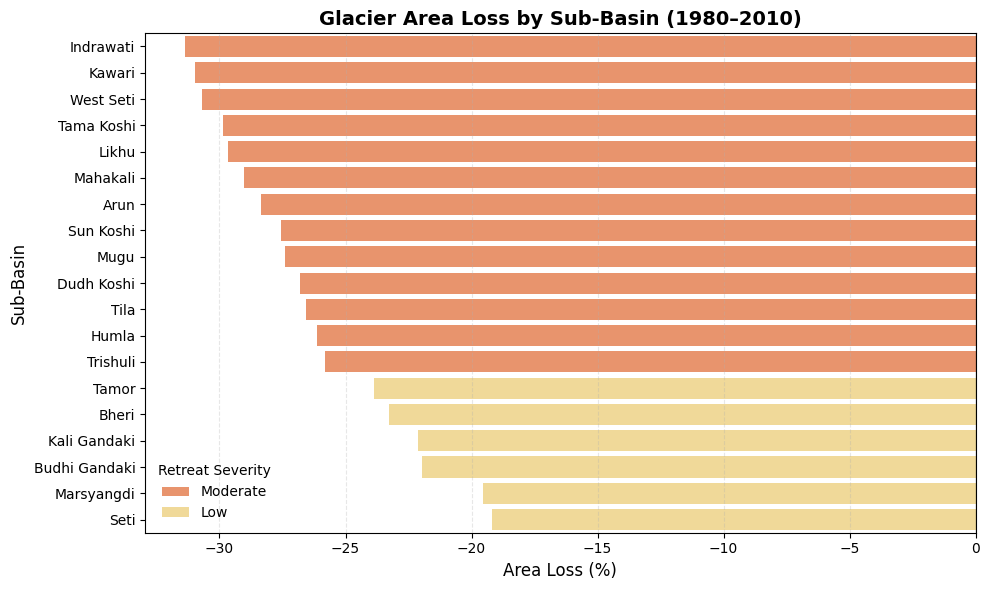

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Ensure area_loss_pct is numeric
glacier_features['area_loss_pct'] = pd.to_numeric(
    glacier_features['area_loss_pct'], errors='coerce'
)

# Step 2: Sort by loss % for ordered plotting
plot_df = glacier_features.sort_values('area_loss_pct', ascending=True)

# Step 3: Define color palette for severity levels
severity_palette = {
    'High': '#d73027',          # Red
    'Moderate': '#fc8d59',      # Orange
    'Low': '#fee08b',           # Yellow
    'No Loss or Gain': '#91bfdb'  # Blue
}

# Step 4: Create horizontal bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=plot_df,
    x='area_loss_pct',
    y='sub-basin',
    hue='retreat_severity',
    palette=severity_palette,
    dodge=False
)

# Step 5: Styling
plt.axvline(0, color='black', linewidth=0.8)
plt.title('Glacier Area Loss by Sub-Basin (1980–2010)', fontsize=14, weight='bold')
plt.xlabel('Area Loss (%)', fontsize=12)
plt.ylabel('Sub-Basin', fontsize=12)
plt.legend(title='Retreat Severity', frameon=False)
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


### Stacked Bar Plot of Glacier Area Lost vs. Remaining

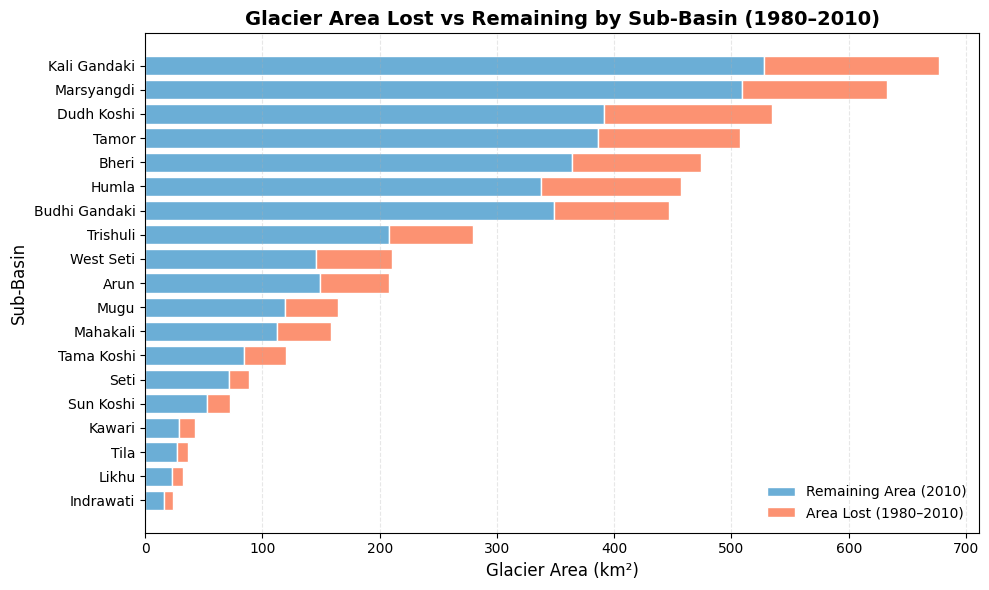

In [114]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Prepare glacier area components
glacier_stack = glacier_features.copy()
glacier_stack['area_remaining'] = glacier_stack['glacier_area_2010']
glacier_stack['area_lost'] = (
    glacier_stack['glacier_area_1980'] - glacier_stack['glacier_area_2010']
).clip(lower=0)  # Avoid negative values

# Step 2: Sort sub-basins by original glacier area (1980)
glacier_stack = glacier_stack.sort_values('glacier_area_1980', ascending=False)

# Step 3: Plot stacked horizontal bars
plt.figure(figsize=(10, 6))

# Base: 2010 glacier area
plt.barh(
    glacier_stack['sub-basin'],
    glacier_stack['area_remaining'],
    label='Remaining Area (2010)',
    color='#6baed6',
    edgecolor='white'
)

# Overlay: Area lost since 1980
plt.barh(
    glacier_stack['sub-basin'],
    glacier_stack['area_lost'],
    left=glacier_stack['area_remaining'],
    label='Area Lost (1980–2010)',
    color='#fc9272',
    edgecolor='white'
)

# Step 4: Styling
plt.title('Glacier Area Lost vs Remaining by Sub-Basin (1980–2010)', fontsize=14, weight='bold')
plt.xlabel('Glacier Area (km²)', fontsize=12)
plt.ylabel('Sub-Basin', fontsize=12)
plt.gca().invert_yaxis()  # Largest area on top
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='', frameon=False, fontsize=10)
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


### ✅ Extract District Centroids (Lat/Lon)

In [116]:
import geopandas as gpd
import pandas as pd

# Step 1: Load the district-level shapefile
gdf = gpd.read_file("../data/local_unit_shapefiles/local_unit.shp")

# Step 2: Normalize district names
gdf['DISTRICT'] = gdf['DISTRICT'].str.strip().str.upper()

# Step 3: Dissolve to get one geometry per district
district_gdf = gdf.dissolve(by='DISTRICT', as_index=False)

# Step 4: Project to UTM Zone 45N (EPSG:32645) for accurate centroid calculation
district_gdf_utm = district_gdf.to_crs(epsg=32645)

# Step 5: Compute centroids in projected CRS
district_gdf_utm['CENTROID'] = district_gdf_utm.geometry.centroid

# Step 6: Reproject centroids to WGS84 (EPSG:4326) for lat/lon
district_centroids_gdf = gpd.GeoDataFrame(
    district_gdf_utm[['DISTRICT']],
    geometry=district_gdf_utm['CENTROID'],
    crs="EPSG:32645"
).to_crs(epsg=4326)

# Step 7: Extract latitude and longitude
district_gdf['CENTROID_LAT'] = district_centroids_gdf.geometry.y
district_gdf['CENTROID_LON'] = district_centroids_gdf.geometry.x

# Step 8: Final output: district name + lat/lon
district_centroids = district_gdf[['DISTRICT', 'CENTROID_LAT', 'CENTROID_LON']].copy()

# Step 9: Preview
print("✅ Spatial Centroids Extracted:")
print(district_centroids.head())


✅ Spatial Centroids Extracted:
       DISTRICT  CENTROID_LAT  CENTROID_LON
0        ACHHAM     29.112404     81.298909
1  ARGHAKHANCHI     27.908325     83.081209
2       BAGLUNG     28.347399     83.252756
3       BAITADI     29.507514     80.572998
4       BAJHANG     29.708035     81.180118


### ✅ Climate + Yield Features at District Centroids in Folium

In [120]:
import folium
import pandas as pd
import geopandas as gpd

# --- Step 1: Normalize district names to lowercase for merge ---
district_centroids['DISTRICT'] = district_centroids['DISTRICT'].str.strip().str.lower()
merged_df['district_name'] = merged_df['district_name'].str.strip().str.lower()

# --- Step 2: Merge climate+yield features with centroids ---
merged_map_df = pd.merge(
    merged_df,
    district_centroids,
    left_on='district_name',
    right_on='DISTRICT',
    how='inner'
)

# --- Step 3: Filter for one specific year (e.g., 2010) ---
map_data = merged_map_df[merged_map_df['year'] == 2010].copy()

# --- Step 4: Create Folium map centered on Nepal ---
m = folium.Map(location=[28.3, 84.0], zoom_start=7, tiles='CartoDB positron')

# --- Step 5: Add markers with tooltips for each district ---
for _, row in map_data.iterrows():
    tooltip = (
        f"<b>{row['district_name'].title()}</b><br>"
        f"Total Yield: {row['total_yield']:.1f} kg/ha<br>"
        f"Avg Temp: {row['avg_temp']:.2f} °C<br>"
        f"Precipitation: {row['annual_precip']:.1f} mm<br>"
        f"Heatwave Days: {int(row['highheat_days'])}"
    )
    
    folium.CircleMarker(
        location=[row['CENTROID_LAT'], row['CENTROID_LON']],
        radius=6,
        color='crimson',
        fill=True,
        fill_opacity=0.75,
        tooltip=tooltip
    ).add_to(m)

# --- Step 6: Save and/or display the interactive map ---
m.save("district_climate_yield_map.html")
m


### ✅ Merge Centroids with Merged Climate and Yield Data

In [122]:
import pandas as pd

# Step 1: Normalize district names for matching
merged_df['district_name'] = merged_df['district_name'].str.strip().str.upper()
district_centroids['DISTRICT'] = district_centroids['DISTRICT'].str.strip().str.upper()

# Step 2: Merge spatial coordinates into the main DataFrame
merged_with_coords = pd.merge(
    merged_df,
    district_centroids,
    left_on='district_name',
    right_on='DISTRICT',
    how='left'
).drop(columns=['DISTRICT'])  # Remove redundant key from right table

# Step 3: Preview result
print(f"✅ Merged Dataset with Spatial Coordinates: {merged_with_coords.shape[0]} rows × {merged_with_coords.shape[1]} columns")
print(merged_with_coords[['district_name', 'year', 'CENTROID_LAT', 'CENTROID_LON']].head())


✅ Merged Dataset with Spatial Coordinates: 1674 rows × 36 columns
  district_name  year  CENTROID_LAT  CENTROID_LON
0  ARGHAKHANCHI  1982     27.908325     83.081209
1  ARGHAKHANCHI  1983     27.908325     83.081209
2  ARGHAKHANCHI  1984     27.908325     83.081209
3  ARGHAKHANCHI  1985     27.908325     83.081209
4  ARGHAKHANCHI  1986     27.908325     83.081209


### ✅ MinMax and Standard Scaling (Merged, Unmerged features)

In [164]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 1. Identify numeric feature columns (exclude ID, year, lat/lon)
numeric_cols = merged_with_coords.select_dtypes(include='number').columns.tolist()
exclude_cols = ['year', 'CENTROID_LAT', 'CENTROID_LON']
features_to_scale = [col for col in numeric_cols if col not in exclude_cols]

# 2. Apply StandardScaler (Z-score normalization)
scaler_standard = StandardScaler()
standard_scaled = pd.DataFrame(
    scaler_standard.fit_transform(merged_with_coords[features_to_scale]),
    columns=[f"{col}_zscore" for col in features_to_scale],
    index=merged_with_coords.index
)

# 3. Apply MinMaxScaler (scale to 0–1)
scaler_minmax = MinMaxScaler()
minmax_scaled = pd.DataFrame(
    scaler_minmax.fit_transform(merged_with_coords[features_to_scale]),
    columns=[f"{col}_minmax" for col in features_to_scale],
    index=merged_with_coords.index
)

# 4. Concatenate scaled features with original dataframe
merged_scaled = pd.concat([merged_with_coords, standard_scaled, minmax_scaled], axis=1)

# 5. Preview result for first scaled feature
first_feature = features_to_scale[0]
print(f"✅ Scaled Dataset: {merged_scaled.shape[0]} rows × {merged_scaled.shape[1]} columns")
print(merged_scaled[[first_feature, f"{first_feature}_zscore", f"{first_feature}_minmax"]].head())


✅ Scaled Dataset: 1674 rows × 100 columns
      bl  bl_zscore  bl_minmax
0  900.0  -0.130672   0.033750
1  900.0  -0.130672   0.033750
2  889.0  -0.141643   0.033337
3  692.0  -0.338133   0.025950
4  714.0  -0.316190   0.026775


### ✅ Dimensionality Reduction (PCA) on Scaled Feature Set

In [166]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Select Z-score normalized columns
zscore_cols = [col for col in merged_scaled.columns if col.endswith('_zscore')]

# 2. Drop rows with missing values in selected columns
X = merged_scaled[zscore_cols].dropna()

# 3. Retain district and year metadata for reference
meta = merged_scaled.loc[X.index, ['district_name', 'year']].reset_index(drop=True)

# 4. Apply PCA to retain 95% of explained variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

# 5. Create DataFrame of principal components
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# 6. Combine PCA results with metadata
pca_result = pd.concat([meta, pca_df], axis=1)

# 7. Print summary and preview
explained_var = pca.explained_variance_ratio_.sum()
print(f"✅ PCA complete: {X_pca.shape[1]} components explain {explained_var:.2%} of variance.")
print(pca_result.head())


✅ PCA complete: 14 components explain 95.65% of variance.
  district_name  year       PC1       PC2       PC3       PC4       PC5  \
0  ARGHAKHANCHI  2010 -1.062089 -1.234252  2.485811 -0.675662 -0.463727   
1  ARGHAKHANCHI  2011  0.531697 -0.723124  2.254362  1.275419 -0.046670   
2  ARGHAKHANCHI  2012  0.958356 -2.401977 -0.179230  0.884412 -1.764773   
3  ARGHAKHANCHI  2013  1.689668 -0.399487  0.494197 -1.135444 -1.161645   
4       BAGLUNG  2010 -1.151181  0.929121  0.239298  0.414325  0.992060   

        PC6       PC7       PC8       PC9      PC10      PC11      PC12  \
0 -0.566349 -2.746430 -0.382833 -0.334761  0.693208 -0.744839 -0.286868   
1  0.834214 -0.364394  0.904240  0.809991  0.542617 -1.375651  0.233926   
2 -0.595347 -1.174719  0.253018 -0.316126  0.965919 -0.644306 -0.952356   
3  0.403019 -1.087301  2.899654  0.353960 -0.632692 -1.341347  0.015777   
4  0.692600 -1.143001 -0.326967 -1.518022  0.990687 -0.973303  0.386694   

       PC13      PC14  
0  1.467419 -0.0

### ✅ Top Contributing Features for Each Principal Component

In [168]:
import pandas as pd
import numpy as np

# Assume `pca` is already fitted and `X.columns` contains the original feature names
loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

# Extract top 5 contributors for each principal component
top_features = {}

print("🔍 Top Contributing Features per Principal Component:")
for pc in loadings.columns:
    # Sort by absolute loading strength
    sorted_loadings = loadings[pc].abs().sort_values(ascending=False)
    top_feats = sorted_loadings.head(5).index.tolist()
    top_features[pc] = top_feats

    # Print formatted output
    print(f"\n📌 {pc} — Top 5 Features:")
    for feat in top_feats:
        raw_weight = loadings.loc[feat, pc]
        print(f"  {feat:<30} → loading: {raw_weight:+.4f}")


🔍 Top Contributing Features per Principal Component:

📌 PC1 — Top 5 Features:
  total_yield_zscore             → loading: +0.3383
  pd_zscore                      → loading: +0.3327
  pd_ma3_zscore                  → loading: +0.3182
  pd_lag1_zscore                 → loading: +0.3025
  wt_ma3_zscore                  → loading: +0.2802

📌 PC2 — Top 5 Features:
  ml_zscore                      → loading: +0.8487
  mz_ma3_zscore                  → loading: +0.2058
  mz_std3_zscore                 → loading: +0.1623
  temp_range_stddev_lag1_zscore  → loading: -0.1412
  avg_max_temp_zscore            → loading: -0.1384

📌 PC3 — Top 5 Features:
  ml_zscore                      → loading: +0.4330
  mz_zscore                      → loading: -0.3057
  pd_std3_zscore                 → loading: +0.2908
  mz_ma3_zscore                  → loading: -0.2839
  mz_lag1_zscore                 → loading: -0.2610

📌 PC4 — Top 5 Features:
  mz_change_zscore               → loading: +0.5653
  mz_zscore    

### ✅ Feature Sets for ML Model Training (Original, Scaled, PCA)

In [170]:
# --- 1. Original numeric features (excluding index-like columns) ---
original_features = merged_with_coords.select_dtypes(include='number').columns.tolist()
print("🔹 Original Numeric Features:")
print(original_features)

# --- 2. Scaled features ---
zscore_features = [col for col in merged_scaled.columns if col.endswith('_zscore')]
minmax_features = [col for col in merged_scaled.columns if col.endswith('_minmax')]

print("\n🔹 Z-Score Scaled Features:")
print(zscore_features)

print("\n🔹 MinMax Scaled Features:")
print(minmax_features)

# --- 3. PCA-reduced features (excluding any metadata columns if present) ---
pca_features = [col for col in pca_df.columns if col.startswith('PC')]

print("\n🔹 PCA-Reduced Features:")
print(pca_features)

# --- 4. Summary ---
print("\n✅ Feature Summary:")
print(f"• Original Numeric Features: {len(original_features)}")
print(f"• Z-Score Scaled Features:   {len(zscore_features)}")
print(f"• MinMax Scaled Features:    {len(minmax_features)}")
print(f"• PCA Components:            {len(pca_features)}")


🔹 Original Numeric Features:
['bl', 'bw', 'ml', 'mz', 'pd', 'wt', 'year', 'total_yield', 'mz_change', 'pd_change', 'wt_change', 'mz_ma3', 'mz_std3', 'pd_ma3', 'pd_std3', 'wt_ma3', 'wt_std3', 'mz_lag1', 'pd_lag1', 'wt_lag1', 'avg_temp', 'avg_max_temp', 'temp_range_stddev', 'annual_precip', 'avg_humidity', 'avg_wind', 'highheat_days', 'precip_zscore', 'avg_temp_lag1', 'annual_precip_lag1', 'precip_zscore_lag1', 'highheat_days_lag1', 'temp_range_stddev_lag1', 'CENTROID_LAT', 'CENTROID_LON']

🔹 Z-Score Scaled Features:
['precip_zscore', 'bl_zscore', 'bw_zscore', 'ml_zscore', 'mz_zscore', 'pd_zscore', 'wt_zscore', 'total_yield_zscore', 'mz_change_zscore', 'pd_change_zscore', 'wt_change_zscore', 'mz_ma3_zscore', 'mz_std3_zscore', 'pd_ma3_zscore', 'pd_std3_zscore', 'wt_ma3_zscore', 'wt_std3_zscore', 'mz_lag1_zscore', 'pd_lag1_zscore', 'wt_lag1_zscore', 'avg_temp_zscore', 'avg_max_temp_zscore', 'temp_range_stddev_zscore', 'annual_precip_zscore', 'avg_humidity_zscore', 'avg_wind_zscore', 'highh

### ✅ Save All Required DataFrames

In [172]:
import os
os.makedirs("../data/preprocessed", exist_ok=True)

# Save all necessary data
climate_yearly.to_csv("../data/preprocessed/climate_yearly.csv", index=False)
merged_with_coords.to_csv("../data/preprocessed/merged_with_coords.csv", index=False)
merged_scaled.to_csv("../data/preprocessed/merged_scaled.csv", index=False)
glacier_features.to_csv("../data/preprocessed/glacier_features.csv", index=False)
glacier_long.to_csv("../data/preprocessed/glacier_long.csv", index=False)

print("✅ All key feature datasets saved.")


✅ All key feature datasets saved.
